import modules

In [507]:
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.fsl import FLIRT
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.interfaces.freesurfer import FSCommand
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface, Merge
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
import nipype.interfaces.spm as spm
from nipype.interfaces.base import Bunch
from nipype.interfaces.freesurfer import ApplyVolTransform, MRIConvert
from nipype.algorithms.misc import Gunzip

In [508]:
# SPM standalone
matlab_cmd = '/usr/local/spm12/run_spm12.sh /usr/local/MCR/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

specify interfaces behaviors

In [509]:
# MATLAB - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/usr/local/MATLAB/R2014a/toolbox/spm12')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# FreeSurfer - Specify the location of the freesurfer folder
fs_dir = '~/nipype_tutorial/freesurfer'
FSCommand.set_default_subjects_dir(fs_dir)

experiment parameters

In [510]:
experiment_dir = '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/firstlevel/'
output_dir = 'output_firstlevel'
working_dir = 'working_firstlevel'

# list of subject identifiers
#subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']
subject_list = ['sub-01']

# TR of functional images
TR = 1.45
number_of_slices = 30
fwhm = [4]

In [511]:
# Condition names
condition_names = ['stress', 'relax', 'stress_gremium']

cont01 = ['stress','T', condition_names, [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
cont02 = ['relax','T', condition_names, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]
cont03 = ['stress > relax','T', condition_names, [1, -1, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0]]
cont04 = ['relax > stress','T', condition_names, [-1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0]]
cont05 = ['stress_gremium','T', condition_names, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]

contrast_list = [cont01, cont02, cont03, cont04, cont05]

specify nodes

In [512]:
# Nodes used in the nipype beginners guide and the handson example

# SpecifyModel - Generates SPM-specific Model (output: session infos for level1design)
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=256),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix (output: spm mat file)
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}}, #basis function (hrf)
                                 timing_units='secs',               # model time derivatives
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'), # model the serial correlation with AR(1) 
                                                                    #(Serial correlations in fMRI time series due to aliased 
                                                                    # biorhythms and unmodelled neuronal activity can be accounted 
                                                                    #for using an autoregressive AR(1) model)
                    name="level1design")

# EstimateModel - estimate the parameters of the model (output: a.o. beta-images)
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}), # other option would be Bayesian
                      name="level1estimate")

# EstimateContrast - estimates contrasts (output: o.a. con_images (t-maps))
level1conest = Node(EstimateContrast(contrasts=contrast_list), name="level1conest")

specify input and output stream

In [513]:
# Selectfiles - to grab the data
templates = {'anat': '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/mindboggle/freesurfer_subjects/{subject_id}/mri/brain.mgz', # anatomical images,
             'func': '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/_subject_id_{subject_id}/smooth/sr{subject_id}_*.nii',
             'mc_param': '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/_subject_id_{subject_id}/realign/rp_{subject_id}*.txt',
             'outliers': '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/_subject_id_{subject_id}/art/art.r{subject_id}_*.txt',
             'mask':  '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/preprocessing/working_dir/preproc_hoaf/_subject_id_{subject_id}/wholebrainmask/*.nii',
            }


selectfiles = Node(SelectFiles(templates, sort_filelist=True),
          name='selectfiles')

selectfiles.iterables = [('subject_id', subject_list)]

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'contrasts',
                                            'mask'],
                                    contrasts=contrast_list),
                  name="infosource")

infosource.iterables = [('subject_id', subject_list)]

# Initiate the datasink node
output_folder = 'datasink'
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_folder),
                name="datasink")

## Use the following substitutions for the DataSink output
substitutions = [('_subj_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

specify contrast

specify GLM

In [514]:
#import pandas as pd
#from os.path import join as opj
#trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
#trialinfo

In [515]:
"""
path = '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/%s/func'%subject_id
file = pd.read_table(opj(path, subject_id+'_task-stress_'+'run-'+run+'_events.tsv'))
# sort stimuli/rows so that they are in the same order like in the behavioral experiments
file['stimuli_cat'] = pd.Categorical(file['trial_type'], categories=['stress', 'relax',  'stress_gremium'], ordered=True)
sorted_file = file.sort_values('stimuli_cat')
sorted_file['stimuli_cat'] = sorted_file['stimuli_cat'].replace(np.nan, 0)
sorted_file = sorted_file[sorted_file.stimuli_cat  != 0]


from os.path import join as opj
import pandas as pd
from nipype.interfaces.base import Bunch
# create lists for each run including the stimuli and their particular onset times
onset_array = []
duration_array = []
stimuli_array = []
for group in sorted_file.groupby('trial_type', sort=False):
    stimuli_array.append(group[0])
    onset_array.append(list(round(group[1].onset,1)))
    duration_array.append(group[1].duration.tolist())
    if run == '1':
        info_run1 = [stimuli_array, onset_array, duration_array]
    elif run == '2':
        info_run2 = [stimuli_array, onset_array, duration_array]
    else :
        print(info_run_error)
"""

"\npath = '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/%s/func'%subject_id\nfile = pd.read_table(opj(path, subject_id+'_task-stress_'+'run-'+run+'_events.tsv'))\n# sort stimuli/rows so that they are in the same order like in the behavioral experiments\nfile['stimuli_cat'] = pd.Categorical(file['trial_type'], categories=['stress', 'relax',  'stress_gremium'], ordered=True)\nsorted_file = file.sort_values('stimuli_cat')\nsorted_file['stimuli_cat'] = sorted_file['stimuli_cat'].replace(np.nan, 0)\nsorted_file = sorted_file[sorted_file.stimuli_cat  != 0]\n\n\nfrom os.path import join as opj\nimport pandas as pd\nfrom nipype.interfaces.base import Bunch\n# create lists for each run including the stimuli and their particular onset times\nonset_array = []\nduration_array = []\nstimuli_array = []\nfor group in sorted_file.groupby('trial_type', sort=False):\n    stimuli_array.append(group[0])\n    onset_array.append(list(round(group[1].onset,1)))\n    duration_array.append(group[1].duration.toli

In [516]:
def get_subject_info(subject_id):   
    
    from nipype.interfaces.base import Bunch
    import pandas as pd
    from os.path import join as opj
    import numpy as np
    
    path = '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/%s/func'%subject_id
    for run in ['1', '2']:
        file = pd.read_table(opj(path, subject_id+'_task-stress_'+'run-'+run+'_events.tsv'))
        # sort stimuli/rows so that they are in the same order like in the behavioral experiments
        file['stimuli_cat'] = pd.Categorical(file['trial_type'], categories=['stress', 'relax',  'stress_gremium'], ordered=True)
        sorted_file = file.sort_values('stimuli_cat')
        sorted_file['stimuli_cat'] = sorted_file['stimuli_cat'].replace(np.nan, 0)
        sorted_file = sorted_file[sorted_file.stimuli_cat  != 0]

        #create lists for each run including the stimuli and their particular onset times
        onset_array = []
        duration_array = []
        stimuli_array = []

        for group in sorted_file.groupby('trial_type', sort=False):
            stimuli_array.append(group[0])
            onset_array.append(sorted(list(round(group[1].onset,1))))
            duration_array.append(sorted(group[1].duration.tolist()))
        if run == '1':
            info_run1 = [stimuli_array, onset_array, duration_array]
        elif run == '2':
            info_run2 = [stimuli_array, onset_array, duration_array]
        else:
            print(info_run_error)


    # create subject_info including all runs
    subject_info=[]
    for r in range(2):
        if r == 0:
            subject_info.insert(r,
                                (Bunch(conditions=info_run1[0],
                                 onsets = info_run1[1],
                                 durations = info_run1[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None)))   
        elif r == 1:
            subject_info.insert(r,
                                (Bunch(conditions=info_run2[0],
                                 onsets = info_run2[1],
                                 durations = info_run2[2],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None))) 
        else: 
            print("error2")          
            
    return(subject_info)

In [517]:
# get subject info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=get_subject_info),
                      name='getsubjectinfo')

specify workflow

In [518]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('mask', 'mask')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (infosource, getsubjectinfo, [('subject_id', 'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                 'subject_info')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters')]),
                    (selectfiles, level1design, [('mask', 'mask_image')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1estimate, datasink, [('mask_image', 'contrasts.@masks')]),
                    (level1conest, datasink, [('spm_mat_file','contrasts.@spm_mat'),
                                              ('spmT_images', 'contrasts.@T'),
                                              ('con_images', 'contrasts.@con')])])

visulize the workflow

In [519]:
# Create 1st-level analysis output graph
#l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
#from IPython.display import Image
#Image('/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/firstlevel/output_firstlevel/graph.png')

Run the Workflow

In [520]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

181122-19:50:26,712 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
181122-19:50:26,731 nipype.workflow INFO:
	 Running in parallel.
181122-19:50:26,734 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 28.21/28.21, Free processors: 4/4.
181122-19:50:26,893 nipype.workflow INFO:
	 [Job 0] Cached (l1analysis.getsubjectinfo).
181122-19:50:26,925 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/firstlevel/working_firstlevel/l1analysis/_subject_id_sub-01/_subject_id_sub-01/selectfiles".
181122-19:50:26,933 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181122-19:50:26,948 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
181122-19:50:28,736 nipype.workflow INFO:
	 [Job 1] Completed (l1analysis.selectfiles).
181122-19:50:28,739 nipype.workflow INFO:
	 [MultiProc] R

Visulize results

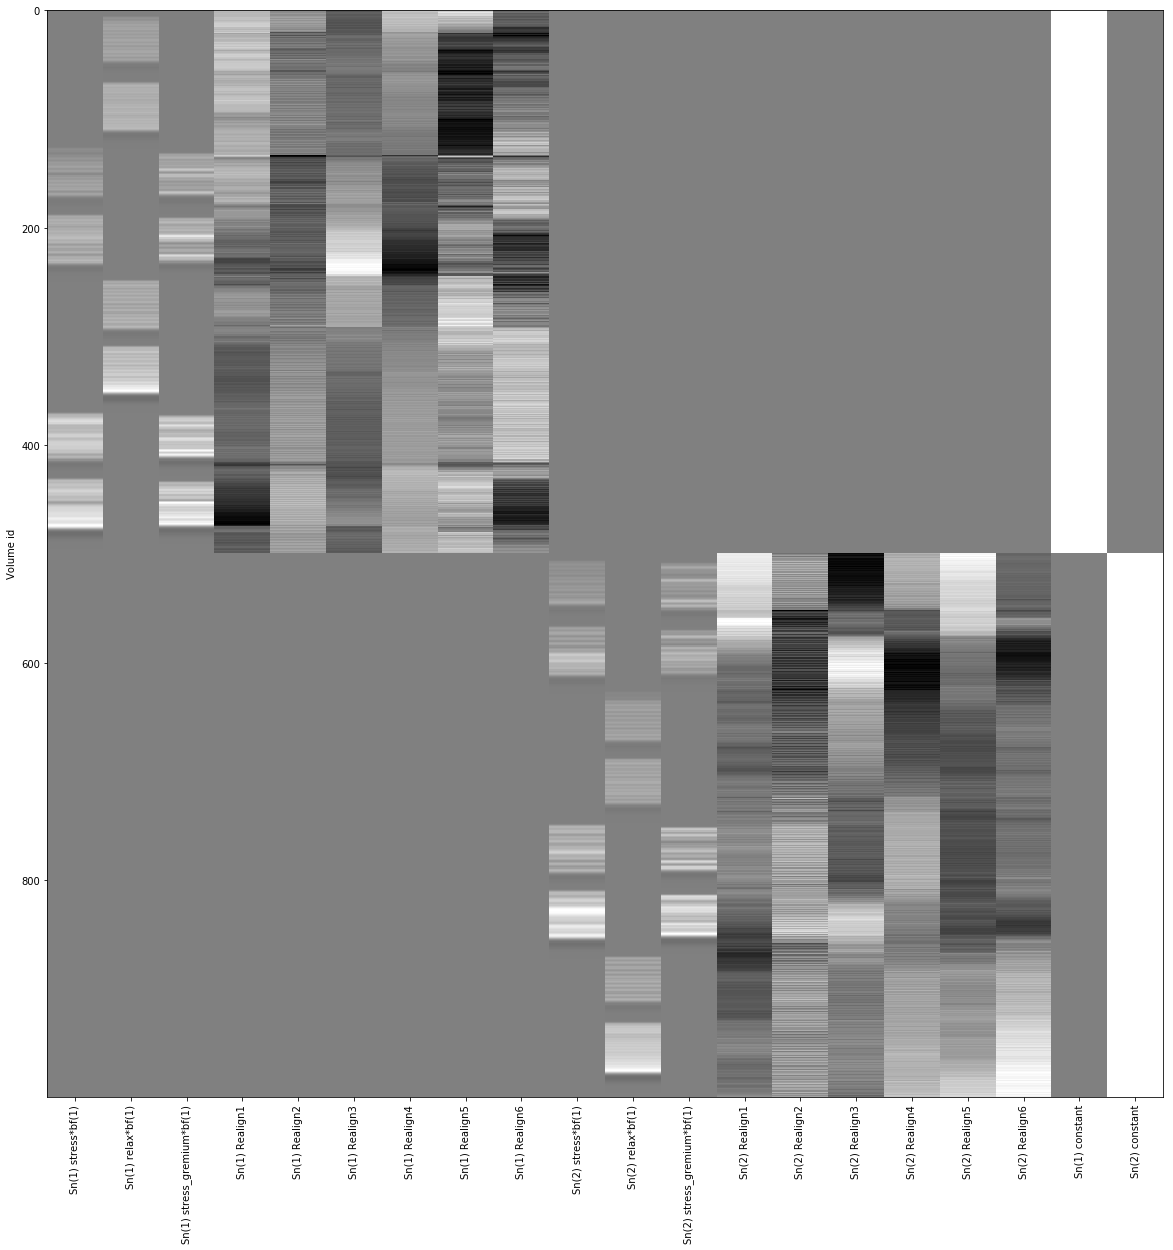

In [521]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/firstlevel/working_firstlevel/l1analysis/_subject_id_sub-01/_subject_id_sub-01/level1design/SPM.mat',
                 struct_as_record=False)

designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

# plot matrix
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

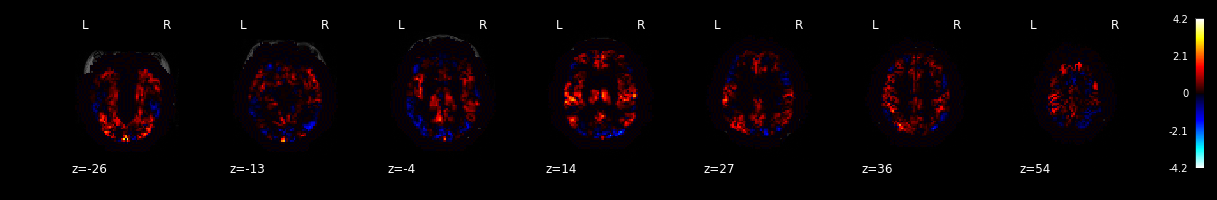

In [525]:
from nilearn.plotting import plot_stat_map
plot_stat_map('/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/derivatives/firstlevel/working_firstlevel/l1analysis/_subject_id_sub-01/_subject_id_sub-01/level1conest/con_0004.nii', 
              '/media/lmn/86A406A0A406933B2/HOAF/HOAF_BIDS/sub-01/anat/sub-01_T1w.nii.gz',display_mode="z")

In [ ]:
"""# plot onsetrelax
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0002.nii',  title='onsetrelax - fwhm=4 - sub-01', bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0)

In [ ]:
"""# plot evaluation
plot_stat_map(stat_map_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/output_preproc/working_firstlevel/l1analysis/_subject_id_sub-00/_subject_id_sub-00/level1conest/spmT_0003.nii', title='evaluation - fwhm=4 - sub-01, bg_img='/home/mirjam/Desktop/Masterarbeit/NC2U_BIDS/derivatives/derivatives/mindboggle/freesurfer_subjects/sub-00/mri/brain.mgz', threshold=2, cut_coords=(-50, 10, 0)